<a href="https://colab.research.google.com/github/DavidEPP/Histopatology-Cancer-Detection-with-CNN/blob/main/CNN_for_cancer_detection_in_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cancer classification using Convolutional Neural Networks

In this notebook, an approach of CNN using Keras (from Tensorflow) will be used to classify cancer diagnose images. This is an approach using convolutional neural networks for the Kaggle competition. The goal will be to maximize the ROC-AUC score for the predicted labels on the test set.

## Dependencies

Tensorflow keras modules are used to generate the neural networks. ImageDataGenerator permits some preprocessing in the images and a better memory usage than smple loops on the image files.

# <a id="0"></a>
<div style="text-align: center; background-color: #03104D; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;">
    <h1>Introduction
🧾</h1>

</div>

The github repositry for this project is in:
https://github.com/DavidEPP/Histopatology-Cancer-Detection-with-CNN/

In [ ]:
#pip install kagglehub tensorflow

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
#import kagglehub
#kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

# histopathologic_cancer_detection_path = kagglehub.competition_download('histopathologic-cancer-detection')
histopathologic_cancer_detection_path = "/Users/david/.cache/kagglehub/competitions/histopathologic-cancer-detection"
print('Data source import complete.')


Data source import complete.


In [2]:
import os
import numpy as np
import pandas as pd
import pickle
import multiprocessing as mp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau



Some variables that will be fixed through the notebook (mostly some parameters for randomness, batch size and cropped image size)

In [3]:
SEED = 412294
np.random.seed(SEED)
tf.random.set_seed(SEED)
BATCH_SIZE = 64
CROP_SIZE = (38, 38)

<div style="background-color: #85DA14; padding: 10px; ">

## Description of the dataset

 The dataset contains a train and a test folder, each of them contains 96x96 pixels images in 3-channels. <br>
 The training folder also contains a dataframe with the ids and labels for each of the files.<br>
 Labels are binary variables where 1 indicates the presence of methastasis and 0 the absence of it in the MIDDLE 32x32 pixels of the picture. (As per the description in the Kaggle competition). The importation of dataframes and the header are shown.

To analyze the dataset, the following is included:
 1. Heading of the training dataframe.
 2. Frequency of positive(1) and negative (0) labels in the training dataframe.
 3. Some full images
 4. The actual tagged images (center of each original image)



In [4]:
train_images = histopathologic_cancer_detection_path+'/train/'
test_images = histopathologic_cancer_detection_path+'/test/'
label_csv = histopathologic_cancer_detection_path+'/train_labels.csv'

full_df = pd.read_csv(label_csv)

full_df['id'] = full_df['id'] + '.tif'

full_df['label'] = full_df['label'].astype(str)

print(full_df.shape)
full_df.head()

(220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


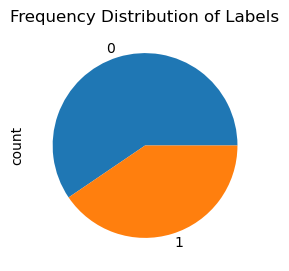

In [5]:
# Calculate frequency distribution
frequency_distribution = (full_df.label.value_counts() / len(full_df)).to_frame()

# Plotting the frequency distribution as a bar chart
plt.figure(figsize=(4, 3))
colors = ['navy', 'red']  #
# Plotting bar chart with specified colors
frequency_distribution.iloc[:, 0].plot(kind='pie', color=colors)

# Customizing chart
plt.title('Frequency Distribution of Labels')

# Show the plot
plt.show()

### Some of the images

The images are 96*96 pixels in 3 channels. The shape of each photo can be seen with the following code:

In [6]:
photo_ex = full_df.iloc[0]['id']
img_ex = mpimg.imread(os.path.join(train_images, photo_ex))
print(img_ex.shape)

(96, 96, 3)


Here a sample of 20 images is shown. The goal of the model is to find the presence of anomalies due to a cancer presence in the central 32*32 pixels of the images.

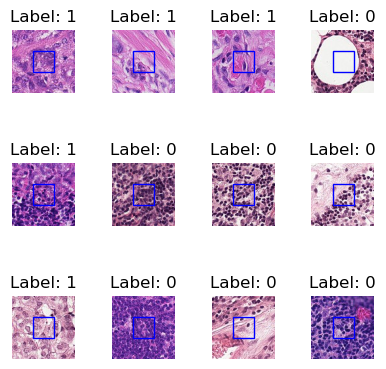

In [7]:
import matplotlib.patches as patches


# Sample 12 images and labels from the training set
sample_images = full_df.sample(12)

# Set up the figure and axes
fig, axes = plt.subplots(3, 4, figsize=(4, 4))
fig.tight_layout(pad=0.05)

# Loop through the images and display each one with its label
for i, ax in enumerate(axes.flat):
    # Get the filename and label for each sample
    photo = sample_images.iloc[i]['id']
    label = sample_images.iloc[i]['label']


    # Load the image from file
    img = mpimg.imread(os.path.join(train_images, photo))

    # Display the image

    ax.imshow(img, cmap='gray')
    # Create a Rectangle patch
    rect = patches.Rectangle((32, 32), 32, 32, linewidth=1, edgecolor='b', facecolor='none')

    # Add the patch to the Axes

    ax.add_patch(rect)

    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.show()


The following images are the actual training objects (central 32x32 pixels x3 channels). The external pixels will be used as padding for the convolutional layer methods. (in other words, this is a 3x zoom to the center of the original images above). It is in this pictures that the labels are going to be predicted.

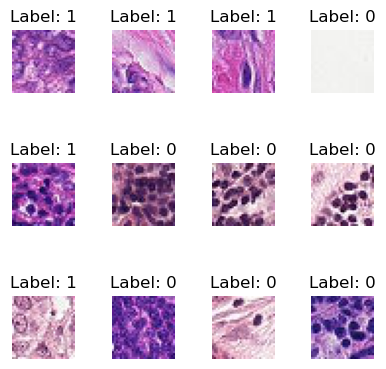

In [8]:

# Set up the figure and axes
fig, axes = plt.subplots(3, 4, figsize=(4, 4))
fig.tight_layout(pad=0.05)

# Loop through the images and display each one with its label
for i, ax in enumerate(axes.flat):
    # Get the filename and label for each sample
    photo = sample_images.iloc[i]['id']
    label = sample_images.iloc[i]['label']


    # Load the image from file
    img = mpimg.imread(os.path.join(train_images, photo))[range(32,64),:,:][:,range(32,64),:]

    # Display the image

    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.show()


## Splitting for training-validation
The training set will be split for validation (later some cross validation may be preferred, but it has to be manually implemented as tensorflow doesn't support it). <br>
Since the algorithm is running in a local machine with no GPU a subset of both the train and validation set are used instead for now in order to (manually) tune the parameters faster.<br>
At the end of the document the same model is trained with the full set, which is expected to get better results, but will use much more time. <br>




30% of the data was taken for validation.
The train and validation sets contain approximately the same ratio of positive labels.
The subsets also have the same ratios.
The histograms for both sets are shown


In [9]:
# Split the data into train_df and valid_df with stratified sampling
TEST_RATIO = 0.3
train_df, valid_df = train_test_split(
    full_df,
    test_size=TEST_RATIO,               # 50% for validation
    stratify=full_df['label'],     # Stratify by the label column to preserve proportions
    random_state=SEED              # Set random seed for reproducibility
)

# Display the size of each dataset to confirm the split
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")





Training set size: 154017
Validation set size: 66008


We can verify that the ratio is the same for validation and training set. Also, since the dataset is rather balanced (balance ratio about $4/6$ ). No data augmentation will be performed.

,train_frequency,valid_frequency
label,,
0,0.594967,0.594973
1,0.405033,0.405027


<Figure size 300x200 with 0 Axes>

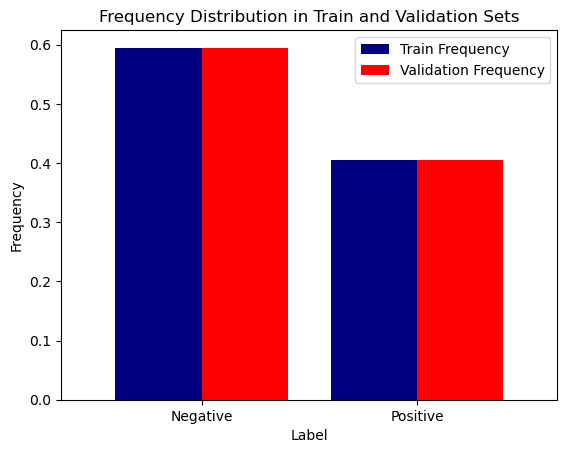

In [10]:
# Calculate the frequencies for training and validation sets
train_frequency = (train_df.label.value_counts() / len(train_df)).to_frame('train_frequency')
valid_frequency = (valid_df.label.value_counts() / len(valid_df)).to_frame('valid_frequency')

# Merging the two dataframes to plot them side by side
frequency_df = pd.concat([train_frequency, valid_frequency], axis=1)
display(frequency_df)

# Plotting the side-by-side bar chart
plt.figure(figsize=(3, 2));
frequency_df.plot(kind='bar', color=['navy', 'red'], width=0.8)

# Customizing chart
plt.title('Frequency Distribution in Train and Validation Sets')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Negative', 'Positive'], rotation=0)
plt.legend(['Train Frequency', 'Validation Frequency'], loc='upper right');

# Show the plot
plt.show();

Same plot is included for the subsets that will be used for a first (fast) tuning of the parameters.

Training mini_set size: 7000
Validation mini_set size: 3000


,train_frequency,valid_frequency
label,,
0,0.587857,0.598333
1,0.412143,0.401667


<Figure size 300x200 with 0 Axes>

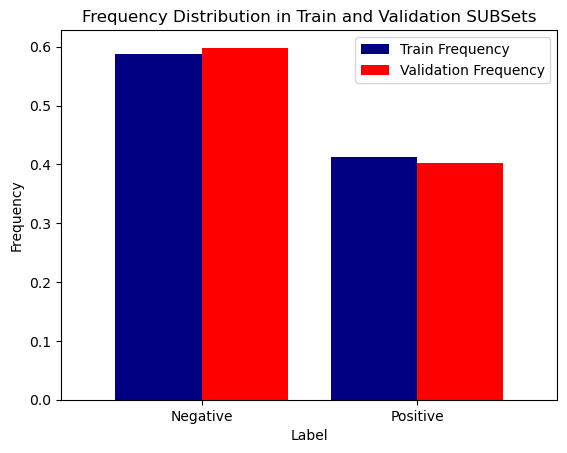

In [11]:
SUBTRAIN_SIZE = 10000
train_df_mini= train_df.sample(int(SUBTRAIN_SIZE*(1-TEST_RATIO)))
valid_df_mini= valid_df.sample(int(SUBTRAIN_SIZE*(TEST_RATIO)))
print(f"Training mini_set size: {len(train_df_mini)}")
print(f"Validation mini_set size: {len(valid_df_mini)}")

# Calculate the frequencies for training and validation sets
train_frequency_mini = (train_df_mini.label.value_counts() / len(train_df_mini)).to_frame('train_frequency')
valid_frequency_mini = (valid_df_mini.label.value_counts() / len(valid_df_mini)).to_frame('valid_frequency')

# Merging the two dataframes to plot them side by side
frequency_df_mini = pd.concat([train_frequency_mini, valid_frequency_mini], axis=1)
display(frequency_df_mini)

# Plotting the side-by-side bar chart
plt.figure(figsize=(3, 2));
frequency_df_mini.plot(kind='bar', color=['navy', 'red'], width=0.8)

# Customizing chart
plt.title('Frequency Distribution in Train and Validation SUBSets')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Negative', 'Positive'], rotation=0)
plt.legend(['Train Frequency', 'Validation Frequency'], loc='upper right');

# Show the plot
plt.show();

In fact, the model performed similarly when trained in the sample and in the full training data. So, because of running time, the sample will be preferred.

## Defining the data generator

Since we only care for the central 3x zoomed image (middle 32x32 pixels), the Images will be cropped before entering the model. The cropping will have some extra pixels so that padding will not be necessary afterwards.<br>
We use an image data loader in order to better loop over each of the images and make some adjustments to training data. This will deal with the possibility of rotations and flipping of images.

In [12]:
# Defining data generator with additional augmentations
pics_datagen = ImageDataGenerator(rescale=1/255
    )

training_datagen = ImageDataGenerator(rescale=1/255,
                                      rotation_range=15,
                                      vertical_flip=True,
                                      horizontal_flip=True
    )

def crop(img, crop_size=(38, 38)):
    # img is expected to be (96, 96, 3)
    height, width = img.shape[0], img.shape[1]
    dx, dy = crop_size
    # Calculate x, y coordinates for cropping
    x = 32-(dx-32)//2
    y = 32-(dx-32)//2
    return img[x:x+dx, y:y+dy]

In [13]:

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator, dataframe, directory, x_col, y_col, batch_size, target_size, crop_size, shuffle=True):
        self.generator = generator.flow_from_dataframe(
            dataframe=dataframe,
            directory=directory,
            x_col=x_col,
            y_col=y_col,
            class_mode='binary',
            batch_size=batch_size,
            target_size=CROP_SIZE,  # cropped size
            shuffle=shuffle,
            num_workers=mp.cpu_count(),
            seed=SEED
        )
        self.crop_size = crop_size
        self.target_size = target_size

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, idx):
        # Get batch of images and labels
        batch_x, batch_y = self.generator[idx]
        # Apply random cropping to each image in the batch
        batch_x_cropped = np.array([crop(img, self.crop_size) for img in batch_x])
        return batch_x_cropped, batch_y


In [14]:
%%time

# Instantiate training and validation loaders
train_loader = CustomDataGenerator(
    generator=training_datagen,
    dataframe=train_df,
    directory=train_images,
    x_col='id',
    y_col='label',
    batch_size=BATCH_SIZE,
    target_size=CROP_SIZE,
    crop_size=CROP_SIZE,  # Center crop size
    shuffle=True
)



Found 154017 validated image filenames belonging to 2 classes.
CPU times: user 2.47 s, sys: 2.26 s, total: 4.74 s
Wall time: 6.82 s


In [15]:
valid_loader = pics_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=train_images,
    x_col='id',
    y_col='label',
    class_mode='binary', # only 2 categories, so one variable is enough
    batch_size=BATCH_SIZE,
    target_size=CROP_SIZE,
    shuffle=False
)

Found 66008 validated image filenames belonging to 2 classes.


*Comment on the dataloader: * In google colab this part had a very short runtime, while in the Kaggle platform, it took a much longer time. I suppose it has to do with the fact that Colab first downloads and extract all the files from the dataset, and perhaps the kaggle platform does that in this stage.

In [16]:
%%time

# Instantiate training and validation loaders
mini_train_loader = CustomDataGenerator(
    generator=pics_datagen,
    dataframe=train_df_mini,
    directory=train_images,
    x_col='id',
    y_col='label',
    batch_size=BATCH_SIZE,
    target_size=CROP_SIZE,
    crop_size=CROP_SIZE,  # Center crop size
    shuffle=True
)
mini_valid_loader = pics_datagen.flow_from_dataframe(
    dataframe=valid_df_mini,
    directory=train_images,
    x_col='id',
    y_col='label',
    class_mode='binary', # only 2 categories, so one variable is enough
    batch_size=BATCH_SIZE,
    target_size=CROP_SIZE,
    shuffle=False
)


Found 7000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.
CPU times: user 176 ms, sys: 161 ms, total: 338 ms
Wall time: 385 ms


## Defining the CNN to be used.

A multilayer CNN will be used. No padding will be needed as the image already contains external pixels that will be used as padding.<br>
The first neural network built has the following architecture:
1. Three Convolutional layers, augmenting the number of parameters. Each using 3x3 patches, relu activation, followed by batch normalization and leakyReLu to improve the performance.
2. A maxpooling layer is done in patches of 3x3 pixels
3. An average pooling to flatten which will give a one dimensional output.
4. Two dense hidden layers with relu activation.
5. A 1-dimensional output layer with sigmoid activation. <br>

Several parameters were tested, namely the learning rate, and the depth of each convolutiional layer and width of dense layers.



In [37]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.regularizers import l2

from tensorflow.keras.layers import Input


# Define the optimizer
learning_rate = 0.01  #
optimizer = Adam(learning_rate=learning_rate)

# Define the CNN architecture using Input object

cnn = Sequential([
    Input(shape=(38, 38, 3)),  # Define the input shape here
    Conv2D(4, (3, 3), activation='relu'),
    BatchNormalization(),
    LeakyReLU(),
#    Dropout(0.2),

    Conv2D(16, (3, 3), activation='relu'),
    BatchNormalization(),
    LeakyReLU(),
#    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    LeakyReLU(),
#    Dropout(0.2),

    MaxPooling2D(2, 2),

     # Global Average Pooling instead of Flatten
    GlobalAveragePooling2D(),
    Dense(16, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid'),

])

# Compile the model with the optimizer, a loss function, and metrics
cnn.compile(optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=[AUC(name='auc')])

cnn.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 36, 36, 4)      │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 36, 36, 4)      │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 36, 36, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 36, 36, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 34, 34, 16)     │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 34, 34, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 34, 34, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 34, 34, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 32, 32, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,433 (44.66 KB)

 Trainable params: 11,265 (44.00 KB)

 Non-trainable params: 168 (672.00 B)

The second architecture tested, uses less dense layers and flattens the convolutional layer differently.

The second neural network built has the following architecture:
1. Three Convolutional layers, augmenting the number of parameters. Each using 3x3 patches, relu activation, followed by batch normalization and leakyReLu to improve the performance.
2. A maxpooling layer is done in patches of 4x4 pixels
3. A flatten layer which will give a one dimensional output.
4. A 1-dimensional output layer with sigmoid activation. <br>

Several parameters were tested, namely the learning rate, and the depth of each convolutiional layer and width of dense layers.


In [45]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.regularizers import l2

from tensorflow.keras.layers import Input


# Define the optimizer
optimizer = Adam(learning_rate=learning_rate)

# Define the CNN architecture using Input object

cnn_2 = Sequential([
    Input(shape=(38, 38, 3)),  # Define the input shape here
    Conv2D(4, (3, 3), activation='relu'),
    BatchNormalization(),
    LeakyReLU(),
#    Dropout(0.2),

    Conv2D(16, (3, 3), activation='relu'),
    BatchNormalization(),
    LeakyReLU(),
#    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    LeakyReLU(),
#   Dropout(0.2),

    MaxPooling2D(2, 2),

     # Global Average Pooling instead of Flatten
    GlobalAveragePooling2D(),
    Dense(16, activation='relu'),
#    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid'),

])



# Compile the model with the optimizer, a loss function, and metrics
cnn_2.compile(optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=[AUC(name='auc')])

cnn_2.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 36, 36, 4)      │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 36, 36, 4)      │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_27 (LeakyReLU)      │ (None, 36, 36, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 34, 34, 16)     │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 34, 34, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_28 (LeakyReLU)      │ (None, 34, 34, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 32, 32, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_29 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,377 (44.44 KB)

 Trainable params: 11,209 (43.79 KB)

 Non-trainable params: 168 (672.00 B)

Considering that the original data has a rather small dimension (32x32x3). Each layer used has a rather small depth, so that the total number of parameters is small and the network can be trained "rather quickyly". <br>
For the compilation, the loss function will be binary crossentropy as it is a simple classification model, and the metric to compute will be ROC-AUC

## Model training, validation and parameters tuning

With the previous parameters the model is trained, first for the subsamples.
 a rather stable AUC score of over 0.8 was achieved for both training and validation.
 extra callbacks are used in the fitting process:
 1. PrintMetricsCallback: to see the progress of the training and partial result after each epoch
 2. Early stopping: if the AUC validation score does not improve after three iterations, the best model is kept.
 3. Reduce learning ratio: When loss is stable, it decreases the learning ratio so that the model doesn't skip possible better parameters.


In [34]:
# Define a custom callback to print loss and AUC after each epoch
class PrintMetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Access the training and validation loss and AUC from logs
        train_loss = logs.get('loss')
        train_auc = logs.get('auc')
        val_loss = logs.get('val_loss')
        val_auc = logs.get('val_auc')

        # Print the stats
        print(f"\nEpoch {epoch + 1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

In [48]:

learning_rate = 0.01  #


# Define number of epochs and an early stopping callback to avoid overfitting
epochs = 20
early_stopping = EarlyStopping(monitor='val_auc', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=0.0001)

# Train the model with the custom PrintMetricsCallback
history = cnn.fit(
    mini_train_loader,
    validation_data=mini_valid_loader,
    epochs=epochs,
    callbacks=[early_stopping, PrintMetricsCallback(), reduce_lr],
    verbose=1
)


Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - auc: 0.7863 - loss: 0.5368
Epoch 1/20 - Train Loss: 0.5433, Train AUC: 0.7837 - Val Loss: 0.4929, Val AUC: 0.8541
110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 221ms/step - auc: 0.7862 - loss: 0.5369 - val_auc: 0.8541 - val_loss: 0.4929 - learning_rate: 3.0000e-04
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - auc: 0.7759 - loss: 0.5518
Epoch 2/20 - Train Loss: 0.5414, Train AUC: 0.7861 - Val Loss: 0.4868, Val AUC: 0.8555
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step - auc: 0.7760 - loss: 0.5517 - val_auc: 0.8555 - val_loss: 0.4868 - learning_rate: 3.0000e-04
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - auc: 0.7774 - loss: 0.5514
Epoch 3/20 - Train Loss: 0.5451, Train AUC: 0.7824 - Val Loss: 0.4905, Val AUC: 0.8557
110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 216ms/step - auc: 0.7774 - loss: 0.5513 - val_auc: 0.8557 - val_loss: 0.4905 - learning_rate: 3.0000e-04
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - auc: 0.7946 - loss: 

In [42]:


# Define number of epochs and an early stopping callback to avoid overfitting
epochs = 20
early_stopping = EarlyStopping(monitor='val_auc', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=0.001)

# Train the model with the custom PrintMetricsCallback
history_2 = cnn_2.fit(
    mini_train_loader,
    validation_data=mini_valid_loader,
    epochs=epochs,
    callbacks=[early_stopping, PrintMetricsCallback(), reduce_lr],
    verbose=1
)


Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - auc: 0.6751 - loss: 0.6466
Epoch 1/20 - Train Loss: 0.6189, Train AUC: 0.7060 - Val Loss: 0.7259, Val AUC: 0.5309
110/110 ━━━━━━━━━━━━━━━━━━━━ 32s 228ms/step - auc: 0.6754 - loss: 0.6464 - val_auc: 0.5309 - val_loss: 0.7259 - learning_rate: 0.0100
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - auc: 0.7425 - loss: 0.5864
Epoch 2/20 - Train Loss: 0.5828, Train AUC: 0.7456 - Val Loss: 0.7875, Val AUC: 0.7696
110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 215ms/step - auc: 0.7425 - loss: 0.5864 - val_auc: 0.7696 - val_loss: 0.7875 - learning_rate: 0.0100
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - auc: 0.7726 - loss: 0.5576
Epoch 3/20 - Train Loss: 0.5669, Train AUC: 0.7613 - Val Loss: 0.5734, Val AUC: 0.7530
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 230ms/step - auc: 0.7725 - loss: 0.5577 - val_auc: 0.7530 - val_loss: 0.5734 - learning_rate: 0.0100
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - auc: 0.7701 - loss: 0.5613
Epoch

The following plot shows both ROC-AUC score and loss for each epoch. We can see that the training AUC remains rather constant, while the validation AUC decreases after the 9th epoch. Three more epochs are attempted, since the AUC score for the validation did not improve, the best model is kept.

In [53]:
# Plot the training and validation accuracy and loss curves
def plot_training_curves(history):
    # Get training and validation metrics
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(auc))

    plt.figure(figsize=(12, 6))

    # Plot AUC
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, auc, label='Training AUC')
    plt.plot(epochs_range, val_auc, label='Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend(loc='lower right')
    plt.title('Training and Validation AUC')

    # Plot Loss
    #plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='center right')
    plt.title('Training and Validation Loss')

    plt.show()



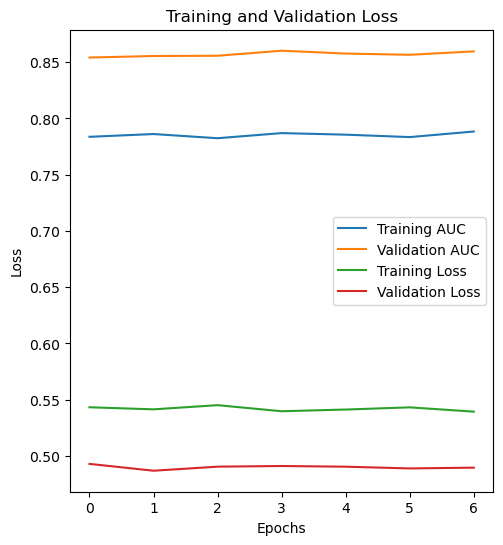

In [54]:
# Call the function to display the curves
plot_training_curves(history)

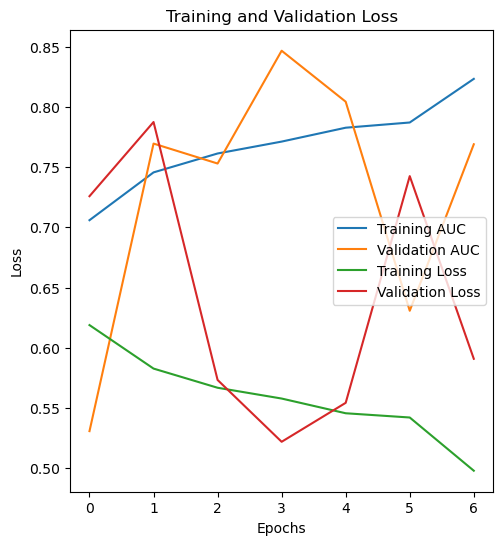

In [55]:
plot_training_curves(history_2)

We can see that the second choice of architecture was much less stable.

## Predicting testing data

To finish the job, the model predicts the labels on the testing set. In fact since AUC is used, only the probabilities vector is computed to generate the corresponding dataframe to be submitted.<br>
The model history is also saved in a separate file. This way we can test the same model on other data.

110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step


/var/folders/87/4f3ypx0j3pd76r7v11n_yvsm0000gn/T/ipykernel_977/1342021887.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_mini['predicted_label'] = mini_train_preds


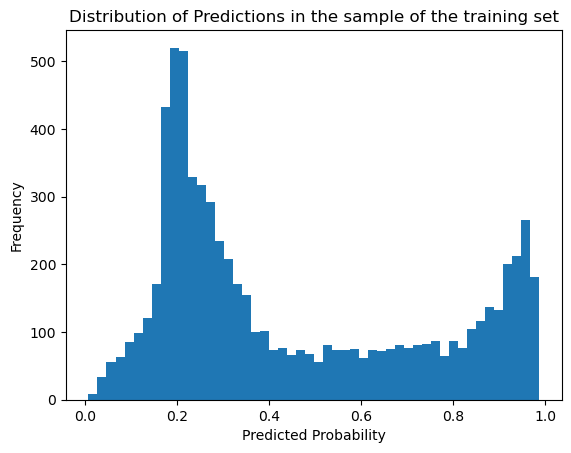

In [ ]:
mini_train_preds = cnn.predict(mini_train_loader)
train_df_mini['predicted_label'] = mini_train_preds
plt.hist(train_df_mini['predicted_label'], bins=50)
plt.title('Distribution of Predictions in the sample of the training set')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()


In [ ]:


test_images = histopathologic_cancer_detection_path+'/test/'

test_df = pd.read_csv(histopathologic_cancer_detection_path+'/sample_submission.csv')

test_df['id'] = test_df['id'] + '.tif'
test_df['label'] = (np.round(np.random.rand(len(test_df))).astype(str))

print('Test Set Size:', test_df.shape)
test_df.head()


Test Set Size: (57458, 2)


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif,1.0
1,95596b92e5066c5c52466c90b69ff089b39f2737.tif,1.0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif,1.0
3,2c35657e312966e9294eac6841726ff3a748febf.tif,0.0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif,0.0


In [ ]:
test_loader = CustomDataGenerator(
    generator=pics_datagen,
    target_size=CROP_SIZE,
    dataframe=test_df,
    directory=test_images,
    x_col='id',
    y_col='label',
    batch_size=BATCH_SIZE,
    crop_size=CROP_SIZE,
    shuffle=False
)


Found 57458 validated image filenames belonging to 2 classes.


In [ ]:
test_preds = cnn.predict(test_loader)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 80s 89ms/step


The following image shows the distribution of predictions for the test set. We can see that the predictions are mostly sure for the negative cases, but predictions for positive cases are less confident. <br>
A rather low score is expected in the test set.
<br>


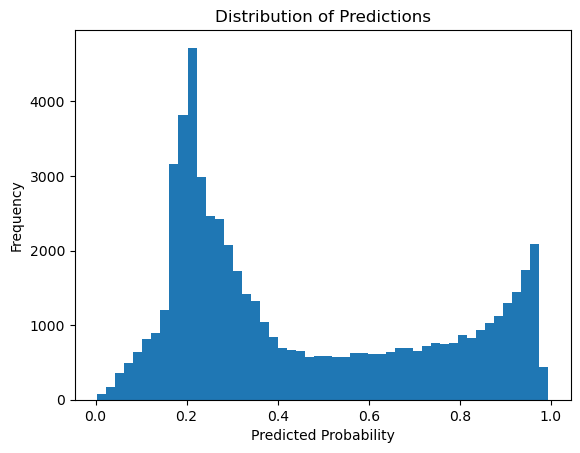

In [ ]:
submission_df = test_df.copy()
submission_df.label= test_preds
submission_df.id = submission_df.id.str.replace('.tif', '')
submission_df.to_csv("submission_short_2.csv", index=False)


plt.hist(submission_df['label'], bins=50)
plt.title('Distribution of Predictions')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()



The prediction distribution for the test set resembles the one for our training set. This lets us expect a similar AUC score.

The score from the best performing shortly trained models are shown.


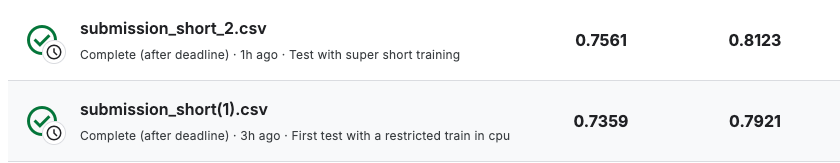

In [ ]:
cnn.save(histopathologic_cancer_detection_path+'/cnn_wk4.keras')
pickle.dump(history, open(f'cnn_history_mini_2.pkl', 'wb'))


In [ ]:
print (histopathologic_cancer_detection_path)

/Users/david/.cache/kagglehub/competitions/histopathologic-cancer-detection


## Training the model in the full test

To obtain better reslts the model training was also performed on the whole validation and training sets. This will take longer and the results from it will be added later.

We can notice the difference in the training time for each epoch.

In [ ]:
# Define a custom callback to print loss and AUC after each epoch
class PrintMetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Access the training and validation loss and AUC from logs
        train_loss = logs.get('loss')
        train_auc = logs.get('auc')
        val_loss = logs.get('val_loss')
        val_auc = logs.get('val_auc')

        # Print the stats
        print(f"Epoch {epoch + 1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

# Define number of epochs and an early stopping callback to avoid overfitting
epochs = 5
early_stopping = EarlyStopping(monitor='val_auc', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=0.001)

# Train the model with the custom PrintMetricsCallback
history = cnn.fit(
    train_loader,
    validation_data=valid_loader,
    epochs=epochs,
    callbacks=[early_stopping, PrintMetricsCallback(), reduce_lr],
    verbose=1
)


Epoch 1/5
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - auc: 0.7719 - loss: 0.5560Epoch 1/5 - Train Loss: 0.5526, Train AUC: 0.7758 - Val Loss: 0.5900, Val AUC: 0.8544
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 646s 268ms/step - auc: 0.7720 - loss: 0.5560 - val_auc: 0.8544 - val_loss: 0.5900 - learning_rate: 0.0010
Epoch 2/5
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - auc: 0.7877 - loss: 0.5415Epoch 2/5 - Train Loss: 0.5393, Train AUC: 0.7895 - Val Loss: 0.5759, Val AUC: 0.8566
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 627s 260ms/step - auc: 0.7877 - loss: 0.5415 - val_auc: 0.8566 - val_loss: 0.5759 - learning_rate: 0.0010
Epoch 3/5
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - auc: 0.7981 - loss: 0.5305Epoch 3/5 - Train Loss: 0.5260, Train AUC: 0.8021 - Val Loss: 0.5539, Val AUC: 0.7873
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 562s 234ms/step - auc: 0.7981 - loss: 0.5305 - val_auc: 0.7873 - val_loss: 0.5539 - learning_rate: 0.0010
Epoch 4/5
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - auc: 0.8087 - loss: 0.517

Now the same network is trained in the full dataset so that the parameters adjust better

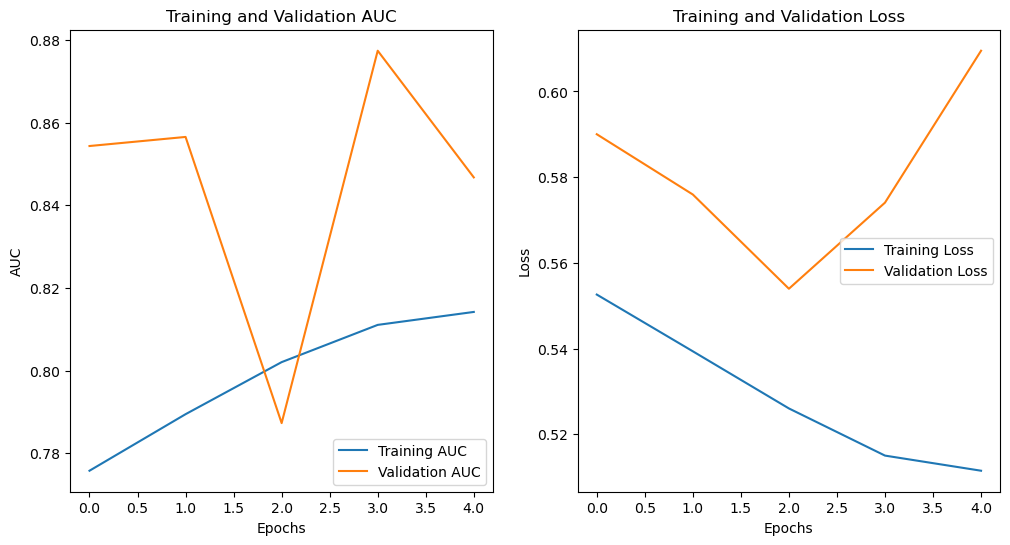

In [ ]:

# Call the function to display the curves
plot_training_curves(history)

2407/2407 ━━━━━━━━━━━━━━━━━━━━ 509s 211ms/step


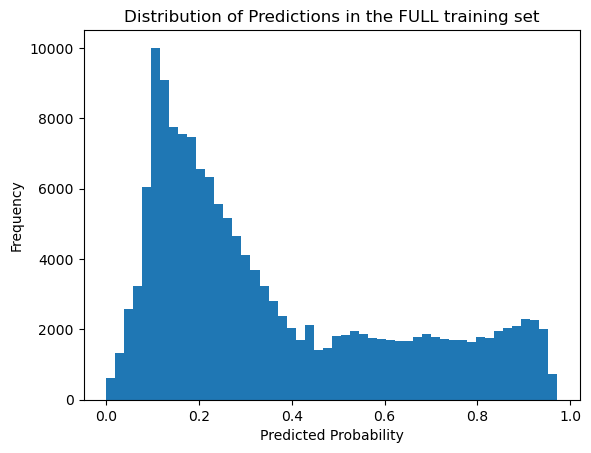

In [ ]:
train_preds = cnn.predict(train_loader)
train_df['predicted_label'] = train_preds
plt.hist(train_df['predicted_label'], bins=50)
plt.title('Distribution of Predictions in the FULL training set')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()


In [ ]:
test_preds = cnn.predict(test_loader)

898/898 ━━━━━━━━━━━━━━━━━━━━ 117s 130ms/step


The following image shows the distribution of predictions for the test set. We can see that the predictions are mostly sure for the negative cases, but predictions for positive cases are less confident. <br>
A rather low score is expected in the test set.
<br>


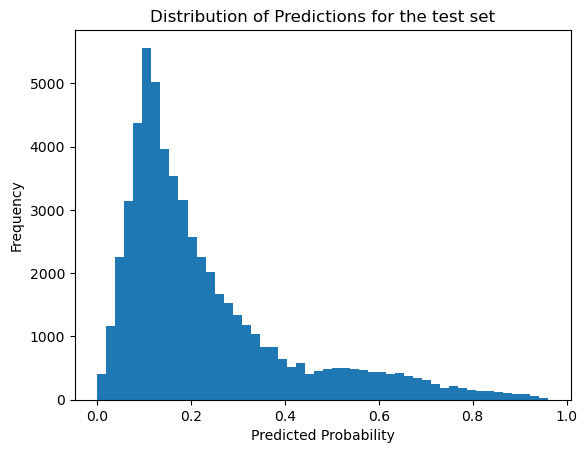

In [ ]:
submission_df = test_df.copy()
submission_df.label= test_preds
submission_df.id = submission_df.id.str.replace('.tif', '')
submission_df.to_csv("submission_long.csv", index=False)


plt.hist(submission_df['label'], bins=50)
plt.title('Distribution of Predictions for the test set')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()



## Conclusions

Training the model in the subsample gave better results as more epochs were compiled until approaching convergence in the training set.<br>
Cross validation might be needed for avoiding overfitting to the data. Nevertheless, some wrapper to sklearn from keras must be done first. This will be done for a future version of the project.<br>
Other types of architectures will be tested, including transfer learning which might be useful for this kind of data, reducing the training time and obtaining better results. But since the main goal of this project was learning about convolutional neural networks, this approach was not yet tested.<br>



## References
From other Kagglers
1. https://www.kaggle.com/code/grainier/histopathologic-cancer-detection-using-cnn